In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time
from ipypb import track

import WRCP_ALS3 as wrcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor
from general_functions import create_filter, hr

### Zero launch of a function(for NUMBA):

In [2]:
init_shape = (100, 100, 10)
coo, vals = gen_coo_tensor(init_shape, density=0.002)
assert check_coo_tensor(coo)!= "Bad"

In [3]:
%%time

max_iter = 12
rank = 5
seed = 13

a, b, c, _, _ = wrcp.wrcp_als3(
    coo, vals, init_shape,
    rank=rank,
    l2=0.25,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)
rerr = sqrt_err_relative(
    coo, vals, init_shape, a, b, c,
)
print(rerr)

0.4148021077431751
CPU times: user 7.27 s, sys: 8.32 ms, total: 7.28 s
Wall time: 7.32 s


### Load the data:

In [4]:
path_data = "Link_Prediction_Data/WN18RR/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))
train_valid_triples = pickle.load(open(path_data + 'train_valid_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

all_triples = train_valid_triples + test_triples

In [5]:
print(entity_list[:3], "\n", len(entity_list))

['00001740', '00001930', '00002137'] 
 40943


In [6]:
print(relation_list[:3], "\n", len(relation_list))

['_also_see', '_derivationally_related_form', '_has_part'] 
 11


In [7]:
len(train_triples)

86835

In [8]:
len(valid_triples)

3034

In [9]:
len(test_triples)

3134

In [10]:
len(train_valid_triples)

89869

In [11]:
test_filter = create_filter(test_triples, all_triples)  
valid_filter = create_filter(valid_triples, all_triples)  

### Create Sparse COO Train Tensor:

In [12]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(40943, 11, 40943)

## WRCP-ALS3:

In [13]:
max_iter = 2
rank = 25
l2 = 3e0
seed = 13

In [14]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

CPU times: user 59.8 s, sys: 155 ms, total: 59.9 s
Wall time: 59.8 s


In [15]:
rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}")

Relative error = 0.49658088525545224


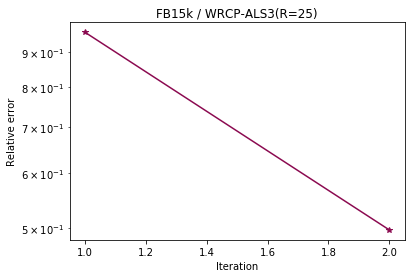

In [16]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"WN18RR / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(1, it+1), err_arr[:it], '-*', c="#8b0a50")

In [17]:
%%time
hr(valid_filter, valid_triples, a, b, c, [1, 3, 10])

CPU times: user 30.3 s, sys: 32 ms, total: 30.3 s
Wall time: 30.4 s


(0.004614370468029005,
 0.0065919578114700065,
 0.013843111404087014,
 0.007630990103543702)

In [18]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

CPU times: user 30.2 s, sys: 16 ms, total: 30.2 s
Wall time: 30.2 s


(0.004148053605615826,
 0.010848755583918315,
 0.018506700701978303,
 0.008887707273917725)

In [19]:
max_iter = [1, 2, 3, 4, 5]
rank = 25
l2 = [1e-2, 1e-1, 1e0, 2e0, 3e0, 4e0, 10e0]
seed = [1, 2, 3, 4, 5, 13, 15, 20]
for iterat in max_iter:
    for l in l2:
        for s in seed:
            a, b, c, err_arr, it = wrcp.wrcp_als3(
                coords, values, data_shape,
                rank=rank,
                l2=l,
                max_iter=iterat,
                seed=s,
                show_iter=False,
                it_over=False,
            ) 
            
            rerr = sqrt_err_relative(
                coords, values, data_shape, a, b, c,
            )
            
            hr1_test, hr3_test, hr10_test, mrr_test = hr(
                test_filter, test_triples, a, b, c, [1, 3, 10],
            )
            print(f"Iter {iterat}; l2 {l}; seed {s}; rerr {rerr}; hr10 {hr10_test}")

Iter 1; l2 0.01; seed 1; rerr 0.03335520989691975; hr10 0.0006381620931716656
Iter 1; l2 0.01; seed 2; rerr 0.02861553174918933; hr10 0.0003190810465858328
Iter 1; l2 0.01; seed 3; rerr 0.02938969816876038; hr10 0.0009572431397574984
Iter 1; l2 0.01; seed 4; rerr 0.025287123615043684; hr10 0.0003190810465858328
Iter 1; l2 0.01; seed 5; rerr 0.026679388543347678; hr10 0.0003190810465858328
Iter 1; l2 0.01; seed 13; rerr 0.028812956983503883; hr10 0.0006381620931716656
Iter 1; l2 0.01; seed 15; rerr 0.02472889281227918; hr10 0.0003190810465858328
Iter 1; l2 0.01; seed 20; rerr 0.03117221828327692; hr10 0.0009572431397574984
Iter 1; l2 0.1; seed 1; rerr 0.04213231091974827; hr10 0.001595405232929164
Iter 1; l2 0.1; seed 2; rerr 0.03823671226553737; hr10 0.0006381620931716656
Iter 1; l2 0.1; seed 3; rerr 0.037969682068715205; hr10 0.0009572431397574984
Iter 1; l2 0.1; seed 4; rerr 0.03350399483208313; hr10 0.0003190810465858328
Iter 1; l2 0.1; seed 5; rerr 0.03534780067014793; hr10 0.00063

KeyboardInterrupt: 

## Find best parameters:

In [20]:
ranks = (25, 50, 100, 200, 300, 400, 600)
l2 = 3e0
n_iter = 2
seed = 13

In [21]:
table_results = pd.DataFrame(
    np.zeros((len(ranks), 14)),
    index=[i for i in range(1, len(ranks) + 1)],
    columns=("iter", "rank", "l2", "time_train",
             "time_hr", "error", "hr1_valid", "hr1_test",
             "hr3_valid", "hr3_test", "hr10_valid", "hr10_test", 
             "mrr_valid", "mrr_test"),
)
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
idx = 0
for rank in track(ranks):
    idx += 1
    # Train model
    start_tr = time.time()
    a, b, c, err_arr, it = wrcp.wrcp_als3(
        coords, values, data_shape,
        rank=rank,
        l2=l2,
        max_iter=n_iter,
        seed=seed,
        show_iter=False,
        it_over=False,
    )
    end_tr = time.time()
            
    # Find relative error
    rerr = sqrt_err_relative(
        coords, values, data_shape, a, b, c,
    )
    
    # Find Hit Rate on a validation set
    start_hr = time.time()
    hr1_valid, hr3_valid, hr10_valid, mrr_valid = hr(
        valid_filter, valid_triples, a, b, c, [1, 3, 10]
    )
    
    # Find Hit Rate on a test set
    hr1_test, hr3_test, hr10_test, mrr_test = hr(
        test_filter, test_triples, a, b, c, [1, 3, 10]
    )
    end_hr = time.time()
            
    table_results.loc[idx]["iter"] = n_iter
    table_results.loc[idx]["rank"] = rank
    table_results.loc[idx]["l2"] = l2
    table_results.loc[idx]["time_train"] = end_tr - start_tr
    table_results.loc[idx]["time_hr"] = end_hr - start_hr
    table_results.loc[idx]["error"] = rerr
    
    table_results.loc[idx]["hr1_valid"] = hr1_valid
    table_results.loc[idx]["hr1_test"] = hr1_test
    
    table_results.loc[idx]["hr3_valid"] = hr3_valid
    table_results.loc[idx]["hr3_test"] = hr3_test
    
    table_results.loc[idx]["hr10_valid"] = hr10_valid
    table_results.loc[idx]["hr10_test"] = hr10_test
    
    table_results.loc[idx]["mrr_valid"] = mrr_valid
    table_results.loc[idx]["mrr_test"] = mrr_test 

 [████████████████████████████████████████████████████████████] 7/7 [03:01:52<01:39:24, 1558.90s/it]

In [23]:
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,2.0,25.0,3.0,49.028272,61.219212,0.496581,0.004614,0.004148,0.006592,0.010849,0.013843,0.018507,0.007631,0.008888
2,2.0,50.0,3.0,69.097993,72.839429,0.504270,0.001978,0.003510,0.006592,0.009253,0.016480,0.018188,0.006618,0.008635
3,2.0,100.0,3.0,131.901831,102.556725,0.493359,0.003955,0.005424,0.008240,0.011487,0.018787,0.022336,0.009344,0.011404
4,2.0,200.0,3.0,458.617133,186.182451,0.471960,0.006262,0.003191,0.010547,0.006063,0.022413,0.020421,0.011904,0.008921
5,2.0,300.0,3.0,1073.498654,261.743319,0.468977,0.008899,0.008934,0.014832,0.017869,0.028016,0.027441,0.015171,0.016022
6,2.0,400.0,3.0,2153.167999,328.318747,0.491871,0.010877,0.008934,0.018128,0.018507,0.033619,0.035099,0.018609,0.018686
7,2.0,600.0,3.0,5485.094754,478.421974,0.469418,0.006922,0.008296,0.010547,0.014997,0.025709,0.026484,0.013021,0.015005


In [24]:
table_results.to_csv("Link_Prediction_Factors/WN18RR/results.csv")

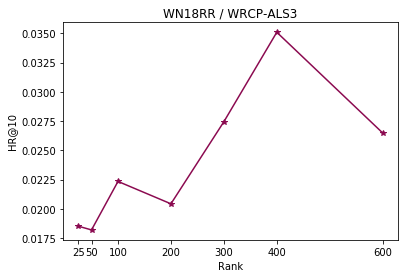

In [25]:
plt.xlabel("Rank")
plt.ylabel("HR@10")
plt.title(f"WN18RR / WRCP-ALS3")
plt.xticks(table_results['rank'])
#plt.yscale("log")
plt.plot(table_results['rank'], table_results['hr10_test'], '-*', c="#8b0a50")